# [G-Research] Crypto Forecasting EDA

<img src = 'https://i.redd.it/qy9ummvzdgz11.jpg' width= '400px'>

<a id="sec1"></a>
# 1 [Description](sec1)

The main target of this competition is to forecast short term returns in 14 popular cryptocurrencies.

This part will include the EDA

<a id="sec1.1"></a>
# 1.1 [Features Defination](sec1.1)

> **train.csv** - The training set
>
>1. **timestamp** - All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
>2. **Asset_ID** - An ID for the cryptoasset
>3. **Count** - The number of trades in this minute.
>4. **Open** - Opening price of the time interval (in USD).
>5. **High** -  Highest price reached during this minute (in USD).
>6. **Low** - The lowest USD price during the minute.
>7. **Close** - The USD price at the end of the minute.
>8. **Volume** - Quantity of asset bought or sold,(USD)
>9. **VWAP** - The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
>10. **Target** 15 minute residualized returns
>
> **asset_details.csv** - Asset information
>
>1. **Asset_ID** - An ID for the cryptoasset
>2. **Weight** - Weight, defined by the competition hosts [here](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)
>3. **Asset_Name** - Human readable asset names.
>
> **example_test.csv** - An example of the data that will be delivered by the time series API.
>
> **example_sample_submission.csv** - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.
>
> **supplemental_train.csv** - After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. In the Evaluation phase, the train, train supplement, and test set will be contiguous in time, apart from any missing data. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.

---
<a id="sec2"></a>
# [2 INDEX 📑](#sec2)
<a id="sec1"></a>
1. [Description](#sec1)
    * [1.1 Features Defination](#sec1.1)
2. [INDEX](#sec2)
3. [Data Loading](#sec3)
4. [Data Loading](#sec4)


---

<a id="sec3"></a>
# 3 [Import Modules](sec3)
[(INDEX)](#sec2)

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colors, pyplot as plt

import warnings
from jupyterthemes import jtplot


In [2]:
%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning)
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

pd.set_option('display.max_rows', 30)  # Show more rows
pd.set_option('display.max_columns', 20)  # Show more columns
plt.style.use('ggplot')  # Nice plotting

<a id="sec4"></a>

# 4 [Data Loading and cheking](sec4)
[(INDEX)](#sec2)

#### Load the data

In [3]:
df_crypto = pd.read_csv('./g-research-crypto-forecasting/train.csv')
asset_details = pd.read_csv('./g-research-crypto-forecasting/asset_details.csv')

In [ ]:
# Taken from Alexis Alvarez
# https://www.kaggle.com/alexisalvarez/eda-resampling-the-power-of-technical-analysis
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
df_crypto.info(show_counts=True)
print(f'Shape of Train Dataset:{df_crypto.shape}\n')
df_crypto.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB
Shape of Train Dataset:(24236806, 10)



,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
14551987,1589997840,1,871.0,9519.937339,9531.70000,9506.70000,9525.221429,7.680823e+01,9522.647463,-0.000431
9771526,1566858000,3,3.0,0.049720,0.04972,0.04972,0.049720,1.923310e+04,0.049720,0.002818
20504085,1616180640,13,651.0,0.057162,0.05719,0.05691,0.056985,8.618527e+06,0.057025,-0.004849


In [5]:
asset_details.info()
print(f'Shape of asset_details:{asset_details.shape}\n')
asset_details.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Asset_ID    14 non-null     int64  
 1   Weight      14 non-null     float64
 2   Asset_Name  14 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 464.0+ bytes
Shape of asset_details:(14, 3)



,Asset_ID,Weight,Asset_Name
2,1,6.779922,Bitcoin
10,3,4.406719,Cardano
8,13,1.791759,TRON


We have 24236806 entries in train dataset. Let's chek

the missing cells

#### Check missing variables

In [6]:
# Show missing cells in percents
for col in df_crypto.columns:
    pct_missing = np.mean(df_crypto[col].isnull())
    print(f'{col} - {round(pct_missing*100,3)}%')

timestamp - 0.0%
Asset_ID - 0.0%
Count - 0.0%
Open - 0.0%
High - 0.0%
Low - 0.0%
Close - 0.0%
Volume - 0.0%
VWAP - 0.0%
Target - 3.096%


We have about 3% of missing data in *target* column.

We will handle it later

There was mentioned in the tutorial for this competition, asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows.

Check it

In [7]:
btc = df_crypto[df_crypto['Asset_ID'] == 1].set_index('timestamp')

In [8]:
(btc.index[1:] - btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

As we can see here are gaps between the timestamps. Normally, the gap shall be equal 60s

But here we have set of different gaps from 120s to 1440s.

For the time series models we need to preprocess our data into a format without time gaps.

Or, we could scrap missed data from the web.

Let's fill gaps with previous valid value


In [9]:
# btc = btc.reindex(range(btc.index[0],btc.index[-1] + 60, 60),method='pad')
# (btc.index[1:] - btc.index[:-1]).value_counts().head()

In [10]:
# add column with coin weight
df_crypto['asset_weight'] = df_crypto['Asset_ID'].map(asset_details.set_index('Asset_ID')['Weight'].to_dict())
# add column with human readable asset name
df_crypto['human_asset_name'] = df_crypto['Asset_ID'].map(asset_details.set_index('Asset_ID')['Asset_Name'].to_dict())

In [11]:
def generate_asset_df(df, asset_name,index=True):
    '''func is call for cleaning timegaps in df
    if index is false, then just generate an asset subset
    '''
    
    if index:
        # generate df
        df_asset = df[df['human_asset_name'] == asset_name].set_index('timestamp')
        # reindex rows with missing timestamps
        df_asset = df_asset.reindex(range(df_asset.index[0],df_asset.index[-1] + 60, 60),method='pad')
        return df_asset
    df_asset = df[df['human_asset_name'] == asset_name]
    return df_asset

In [12]:
crypto = pd.DataFrame(data=None)
# clean time gaps in all dataset 
for asset_name in df_crypto['human_asset_name'].unique():
    crypto = pd.concat([crypto, generate_asset_df(df_crypto,asset_name)],axis=0)

In [14]:
# check what have we got
btc = crypto[crypto['Asset_ID'] == 1]
(btc.index[1:] - btc.index[:-1]).value_counts()

60    1956959
Name: timestamp, dtype: int64

<a id="sec5"></a>

# 5 [EDA](sec5)
[(INDEX)](#sec2)

## Data overview

In [15]:
df_1 = crypto.copy()
crypto = crypto.reset_index()

In [ ]:
crypto = df_1.copy()
crypto = crypto.reset_index()

For the saving time of the preprocessing during EDA 

let's create dataframe and re-sample the minute-wise crypto to daily samples and to hourly

In [16]:
crypto['timestamp'] = crypto['timestamp'].astype('datetime64[s]')

In [ ]:
# train_daily = pd.DataFrame()
# subset = generate_asset_df(crypto,'Bitcoin',index=False)

In [17]:
daily_df = pd.DataFrame()
for asset_name in crypto['human_asset_name'].unique():
    subset = generate_asset_df(crypto,asset_name,index=False)
    subset_new = subset[['timestamp', 'Count']].resample('D', on='timestamp').sum()
    subset_new['open'] =  subset[['timestamp', 'Open']].resample('D', on='timestamp').first()['Open']
    subset_new['high'] = subset[['timestamp','High']].resample('D', on='timestamp').max()['High']
    subset_new['low'] = subset[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    subset_new['close'] = subset[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    subset_new['volume'] = subset[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    subset_new['Asset_ID'] = subset['Asset_ID'].unique()[0]
    subset_new['human_asset_name'] = asset_name
    
    daily_df = daily_df.append(subset_new.reset_index(drop=False))
    daily_df = daily_df.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

In [18]:
#daily_df.to_csv('./daily_df.csv')

In [18]:
def plot_candlestick(df, name):
    '''call for plotting candlesticks'''
    fig = go.Figure(data=[go.Candlestick(
        x=df['timestamp'], 
        open=df['open'], 
        high=df['high'], 
        low=df['low'], 
        close=df['close'])])
    fig.update_layout(title='CandleStick for' + ' ' + str(name),
                     xaxis_title='Date',
                     yaxis_title='Price in USD for' + ' ' + str(name),
                     xaxis_rangeslider_visible = False)
    fig.update_layout(width=1200)
    fig.update_layout(height=600)
    fig.show()

In [19]:
def plot_volume(df, name):
    '''call for plotting volume'''
    fig = go.Figure(data=[go.Bar(
        x=df['timestamp'],y=df['volume'])]) 
    fig.update_layout(title='Volume for' + ' ' + str(name),
                     xaxis_title='Date',
                     yaxis_title='Volume in USD for' + ' ' + str(name))
    fig.update_layout(width=1200)
    fig.update_layout(height=300)
    
    fig.show()

In [20]:
import mplfinance as mpf
def mplplot(df, name):  
    df= df.set_index('timestamp')
    #df['timestamp'] = pd.to_datetime(df.timestamp, utc=False)
    titletext =  name + ' ' + 'MPL Finance OHLC Plot'
    mpf.plot(df,
             type='candle',
             volume=True,
             mav=(7,14,28),
             figratio=(5,2), 
             style='charles',
             title= titletext)

In [ ]:
# plot it
for asset_name in daily_df['human_asset_name'].unique():
    plot_candlestick(generate_asset_df(daily_df,asset_name,index=False),asset_name)
    plot_volume(generate_asset_df(daily_df,asset_name,index=False),asset_name)
#     try:
#         mplplot(generate_asset_df(daily_df,asset_name,index=False)[300:400],asset_name)
#     except:
#         print('fail')

In [ ]:
def plot_close_val(data_frame, column, stock):
    sns.set_style('whitegrid')
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(16,6))
    plt.title(column + ' Price History for ' + stock )
    plt.plot(data_frame[column],color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))
    plt.xlabel('Date')#, fontsize=18)
    plt.ylabel(column + ' for ' + stock )#, fontsize=18)
    plt.show()

## Bitcoin price and Google Trends

Let's check whether the price depends on the mentioning of related requests in google

To do so, let's download the trends from google

We will check only one request "bitcoin"

In [21]:
from pytrends.request import TrendReq
from pytrends import dailydata
pytrends = TrendReq(hl='en-US', tz=360)

In [37]:
# Make a request to google trends
data_trends = dailydata.get_daily_data("bitcoin", 2018,1 , 2021,9)

bitcoin:2018-01-01 2018-01-31
bitcoin:2018-02-01 2018-02-28
bitcoin:2018-03-01 2018-03-31
bitcoin:2018-04-01 2018-04-30
bitcoin:2018-05-01 2018-05-31
bitcoin:2018-06-01 2018-06-30
bitcoin:2018-07-01 2018-07-31
bitcoin:2018-08-01 2018-08-31
bitcoin:2018-09-01 2018-09-30
bitcoin:2018-10-01 2018-10-31
bitcoin:2018-11-01 2018-11-30
bitcoin:2018-12-01 2018-12-31
bitcoin:2019-01-01 2019-01-31
bitcoin:2019-02-01 2019-02-28
bitcoin:2019-03-01 2019-03-31
bitcoin:2019-04-01 2019-04-30
bitcoin:2019-05-01 2019-05-31
bitcoin:2019-06-01 2019-06-30
bitcoin:2019-07-01 2019-07-31
bitcoin:2019-08-01 2019-08-31
bitcoin:2019-09-01 2019-09-30
bitcoin:2019-10-01 2019-10-31
bitcoin:2019-11-01 2019-11-30
bitcoin:2019-12-01 2019-12-31
bitcoin:2020-01-01 2020-01-31
bitcoin:2020-02-01 2020-02-29
bitcoin:2020-03-01 2020-03-31
bitcoin:2020-04-01 2020-04-30
bitcoin:2020-05-01 2020-05-31
bitcoin:2020-06-01 2020-06-30
bitcoin:2020-07-01 2020-07-31
bitcoin:2020-08-01 2020-08-31
bitcoin:2020-09-01 2020-09-30
bitcoin:20

In [69]:
def plot_trend_to_price(df_1,df_2,year=None,by_year=True):
    '''Function called to plot trend of google over the price of coin
    by_year - True. plot dedicated year
    '''
    #generate subset
    df_sub = generate_asset_df(df_1, 'Bitcoin', index=False)
    df_trend = df_2.reset_index()
    
    if by_year:
        # select precise year and create new asset dataframe
        df_sub = df_sub[df_sub['timestamp'].dt.year == year]
        df_trend = df_trend[df_trend['date'].dt.year == year]
        
    scaler = StandardScaler()
    cols_to_scal_1 = ['open', 'close', 'high','low','volume']
    df_sub[cols_to_scal_1] = scaler.fit_transform(df_sub[cols_to_scal_1])
    cols_to_scal_2 = ['bitcoin_unscaled']
    df_trend[cols_to_scal_2] = scaler.fit_transform(df_trend[cols_to_scal_2])
    
    #Create rolled mean for 50 days
    df_trend['rolled50'] = df_trend['bitcoin_unscaled'].rolling(window=50).mean()
    
    plt.figure(figsize=(20,10))
    sns.lineplot(data = df_sub, x='timestamp', y='close',label='BTC close price')#,color="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)]))
    #sns.lineplot(data = df_trend, x='date', y='bitcoin_unscaled', label='Google trend rate')
    sns.lineplot(data = df_trend, x='date', y='rolled50', label='Google trend (Rolled mean)')
    plt.title(f'Google trend Vs BTC price in {year} Year')
    plt.show()
    

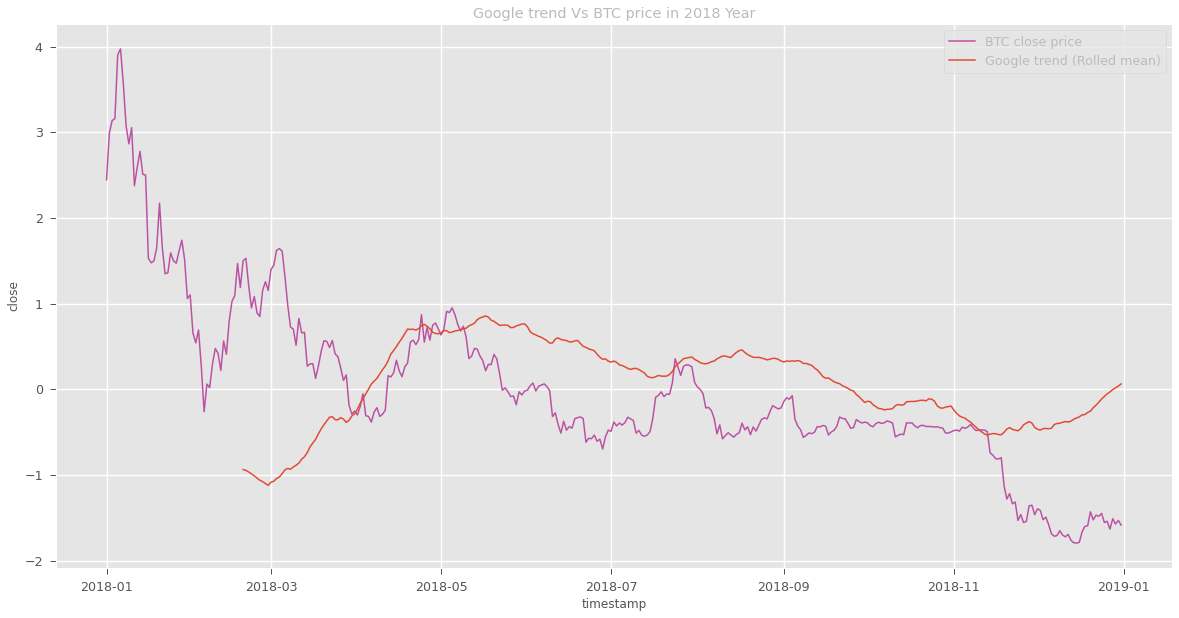

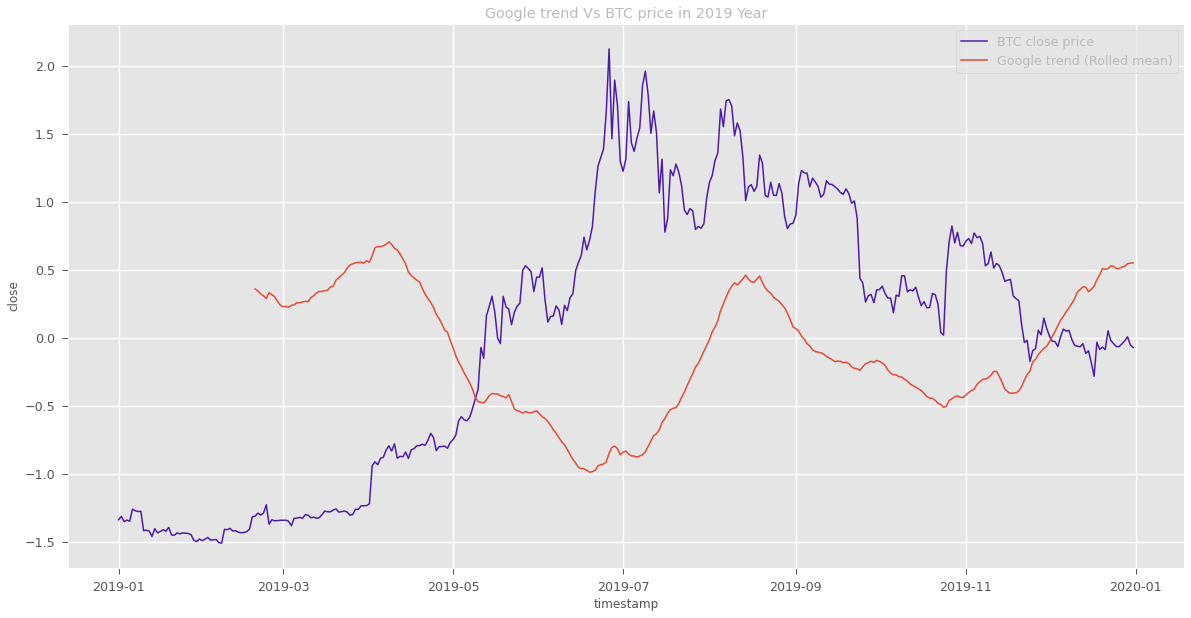

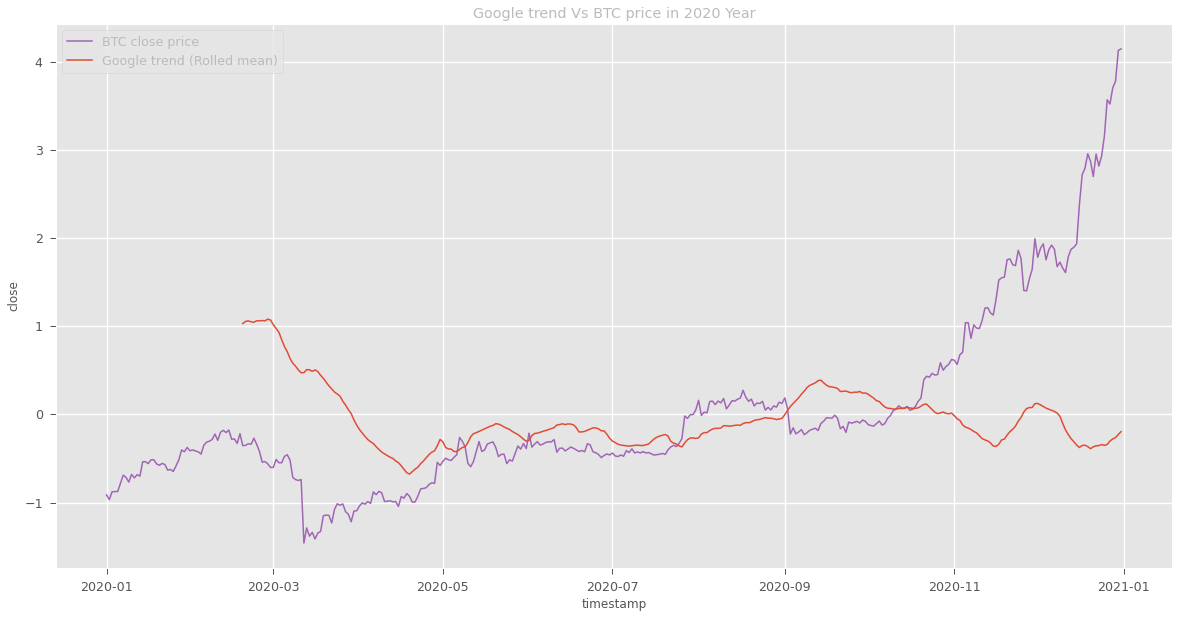

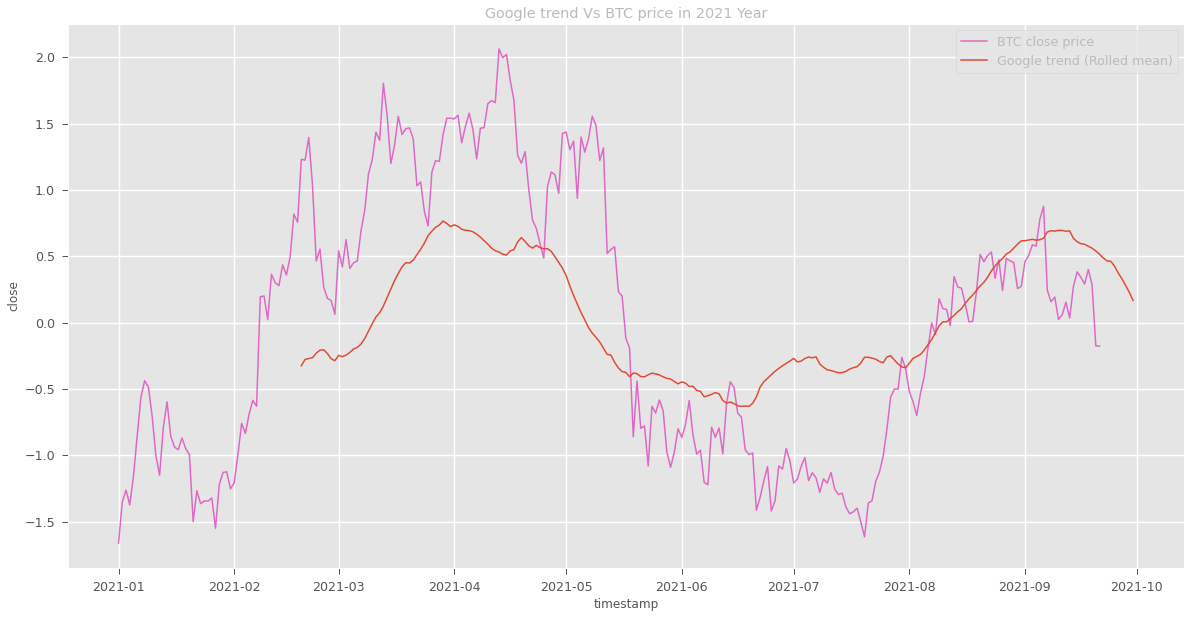

In [70]:
# Let's plot yearly curves
for year in range (2018,2022,1):
    plot_trend_to_price(daily_df,data_trends,year)

Well, seems the trends in google are somehow correlated with the price of Bitcoin

Let's check All Time curves

/home/paul/Projects/G-Research-Crypto-Forecasting/venv/lib/python3.8/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


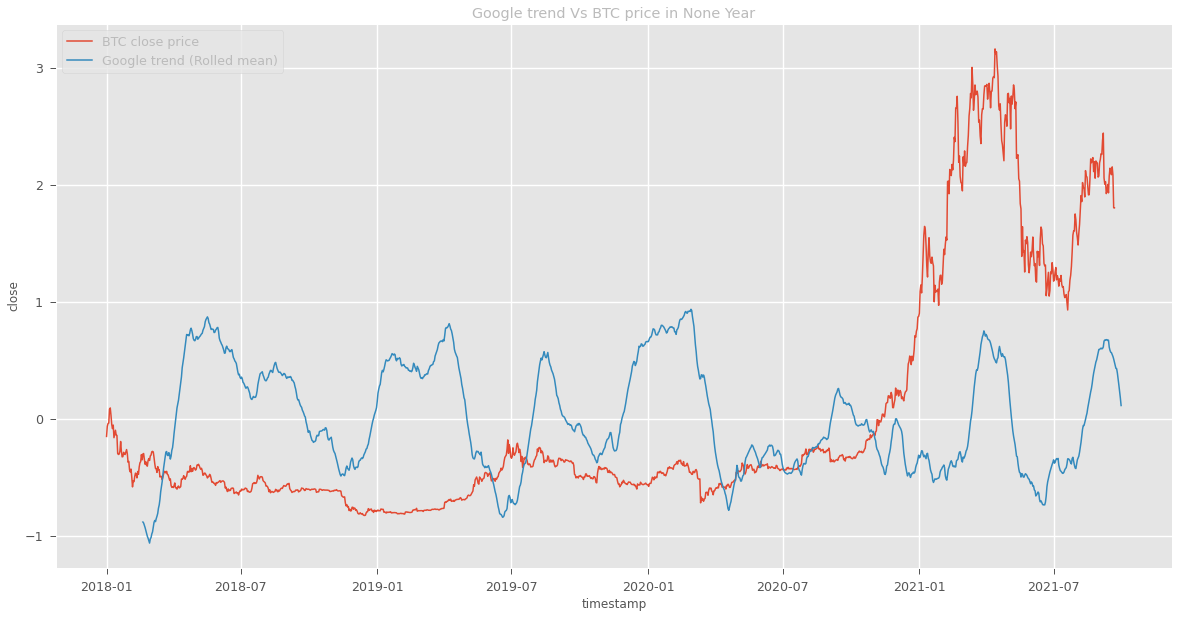

In [66]:
plot_trend_to_price(daily_df,data_trends,by_year=False)

All The time curves are not so interesting as yearly curves. Visaully. only several parts of the time series correlated. Let's check the corr matrix

## Is the Bitcoin a pump driver for Altcoins?

In [149]:
daily_df['human_asset_name'].unique()

array(['Binance Coin', 'Bitcoin', 'Bitcoin Cash', 'EOS.IO', 'Ethereum',
       'Ethereum Classic', 'Litecoin', 'Monero', 'TRON', 'Stellar',
       'Cardano', 'IOTA', 'Maker', 'Dogecoin'], dtype=object)

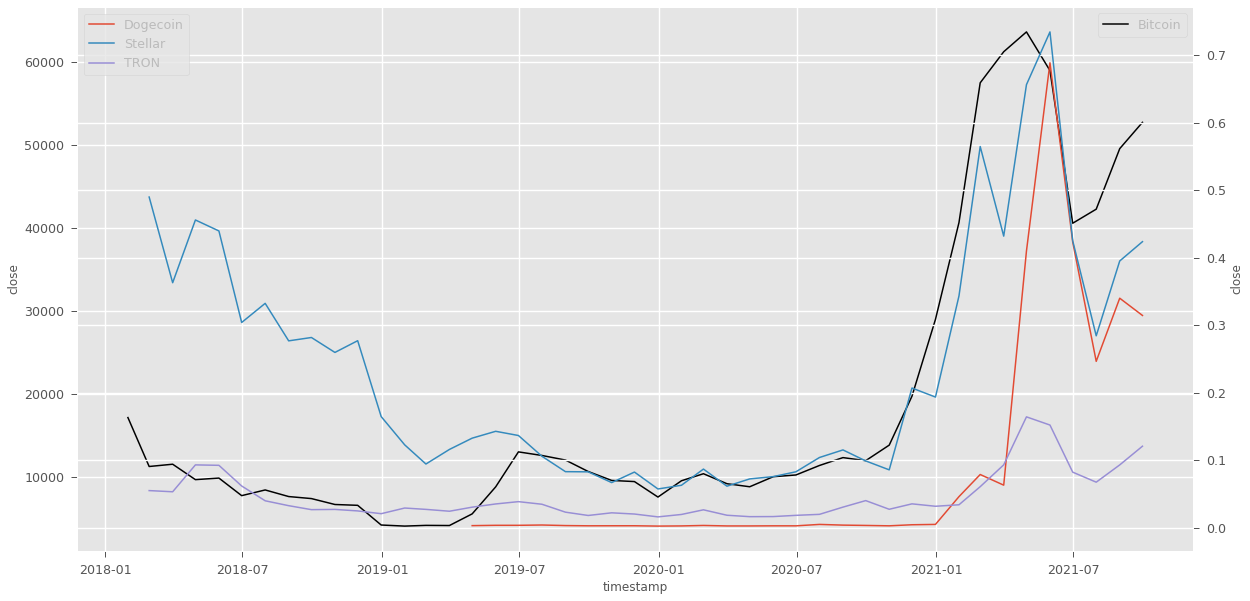

In [155]:
# Create a df where assets willl be grouped by month and agg max close price
monthly_groupped = daily_df.set_index('timestamp')[['human_asset_name','close']].groupby([
    pd.Grouper('human_asset_name'),
    pd.Grouper(freq='M')
]).max().reset_index()

# create butcoin df
sub_btc = generate_asset_df(groupp, 'Bitcoin', index=False)
altcoin_group = ['Stellar','TRON','Dogecoin']

altcoins = monthly_groupped[(monthly_groupped["human_asset_name"].isin(altcoin_group))]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax2 = ax.twinx()
palette ={"Bitcoin": "#000000"}
sns.lineplot(data=sub_btc, x="timestamp", y="close", hue="human_asset_name",err_style="bars",ax=ax, palette=palette)
ax.legend(loc=1)
sns.lineplot(data=altcoins, x="timestamp", y="close",hue="human_asset_name", ax=ax2)
ax2.legend(loc=2)
plt.show()

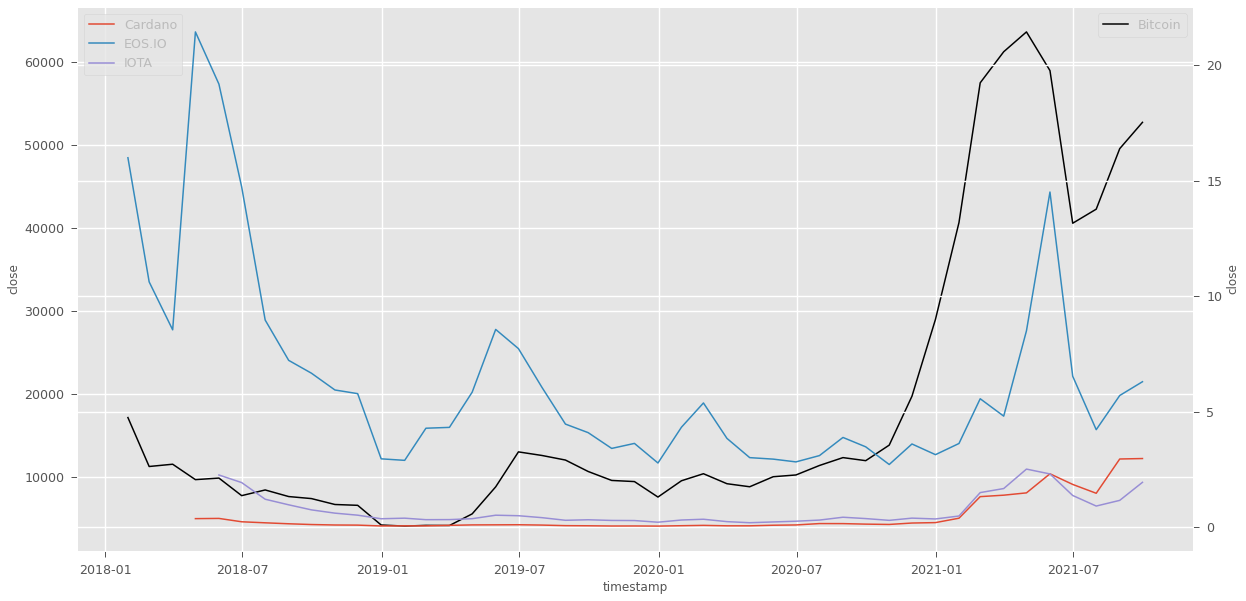

In [156]:
altcoin_group = ['Cardano', 'IOTA', 'EOS.IO']

altcoins = monthly_groupped[(monthly_groupped["human_asset_name"].isin(altcoin_group))]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax2 = ax.twinx()
palette ={"Bitcoin": "#000000"}
sns.lineplot(data=sub_btc, x="timestamp", y="close", hue="human_asset_name",err_style="bars",ax=ax, palette=palette)
ax.legend(loc=1)
sns.lineplot(data=altcoins, x="timestamp", y="close",hue="human_asset_name", ax=ax2)
ax2.legend(loc=2)
plt.show()

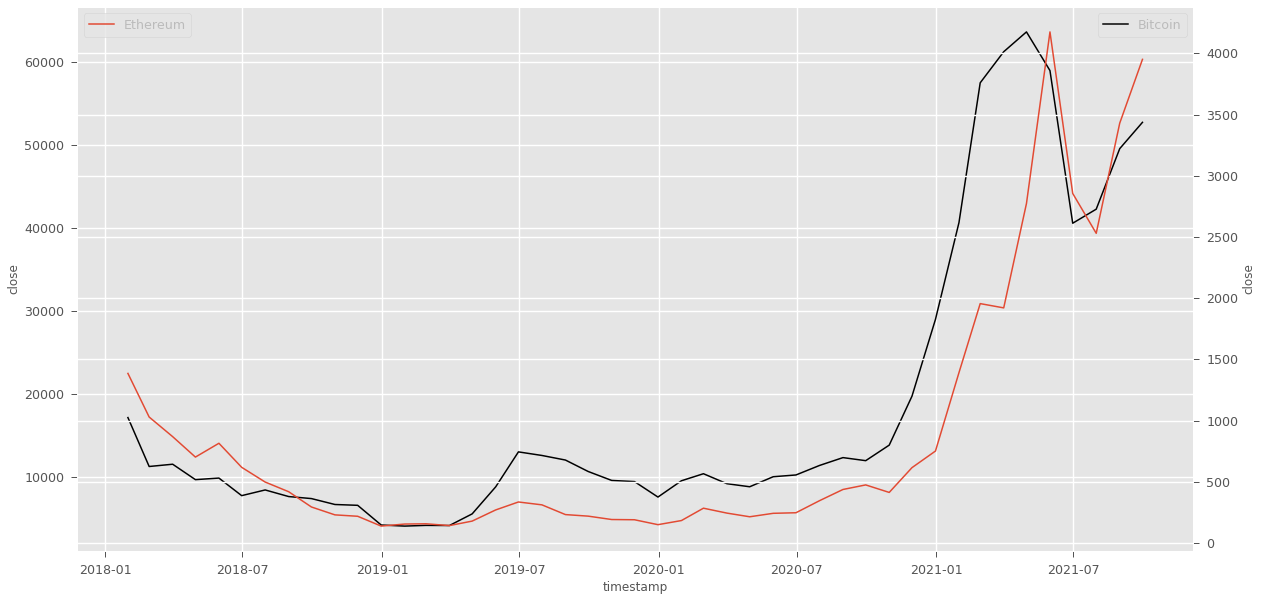

In [157]:
altcoin_group = ['Ethereum']

altcoins = monthly_groupped[(monthly_groupped["human_asset_name"].isin(altcoin_group))]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax2 = ax.twinx()
palette ={"Bitcoin": "#000000"}
sns.lineplot(data=sub_btc, x="timestamp", y="close", hue="human_asset_name",err_style="bars",ax=ax, palette=palette)
ax.legend(loc=1)
sns.lineplot(data=altcoins, x="timestamp", y="close",hue="human_asset_name", ax=ax2)
ax2.legend(loc=2)
plt.show()

## Stationarity


Let's check, whether our time series has stationarity or no.

Let's decompose each of time series

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
daily_df_1 = daily_df#.set_index('timestamp')
daily_df_1

In [ ]:
subset = generate_asset_df(daily_df_1,'Bitcoin',index=False)

In [ ]:
# decomposition = seasonal_decompose(subset['open'], model='additive') 
# decomposition.plot()
# plt.show() 

In [ ]:
# trend_part = decomposition.trend # отдельно трендовая составляющаяя
# seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
# residual_part = decomposition.resid # отдельно шум: то, что осталось

In [143]:
subset['yearmonth'] = subset['timestamp'].astype(str).str[:4]

/tmp/ipykernel_32342/750273676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['yearmonth'] = subset['timestamp'].astype(str).str[:4]


In [144]:
bit_2018 = subset[subset['yearmonth'] == '2018'].set_index('timestamp')

In [145]:
decomposition = seasonal_decompose(bit_2018['open'], model='additive') 
decomposition.plot()
plt.show() 

NameError: name 'seasonal_decompose' is not defined

In [ ]:
# def time_series_features(df, dt_col='Date', label=None):
#     """
#     Creates time series features from datetime index.
#     """
#     df = df.copy()
#     df['hour'] = df[dt_col].dt.hour
#     df['dayofweek'] = df[dt_col].dt.dayofweek
#     df['quarter'] = df[dt_col].dt.quarter
#     df['month'] = df[dt_col].dt.month
#     df['year'] = df[dt_col].dt.year
#     df['dayofyear'] = df[dt_col].dt.dayofyear
#     df['dayofmonth'] = df[dt_col].dt.day
#     df['weekofyear'] = df[dt_col].dt.isocalendar().week
#     return df

# crypto = time_series_features(crypto)

# GOOGLE TRENDS

In [ ]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)

In [ ]:
kw_list = ["crypto","bitcoin",'binance'] # list of keywords to get data 
pytrends.build_payload(kw_list, cat=0, timeframe='today 12-m') 

In [ ]:
kw_list = ["crypto","bitcoin",'binance']
data_2018 = pytrends.get_historical_interest(kw_list, year_start=2018, 
                                 month_start=1, day_start=1, 
                                 hour_start=0, year_end=2018, 
                                 month_end=12, day_end=31, 
                                 hour_end=23, cat=0, sleep=.1)

In [ ]:
data_2018 = data_2018.reset_index()

In [ ]:
#data_2018 = pytrends.interest_over_time() 
data_2018 = data_2018.reset_index() 

In [ ]:
import plotly.express as px

fig = px.line(data_2018, x="date", y=['crypto','bitcoin','binance'], title='Keyword Web Search Interest Over Time')
fig.show()

In [ ]:
data_2018.to_csv('./houly_trends_2018.csv')